# Data Preparation

In [1]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

## Downloads

---

**IMPORTANT** --> Add downloads

* `model.geojson.zip`: http://arturo.300000kms.net/data/model.geojson.zip
* `votes.json`: http://www.atnight.ws/_imperdible/out/votes.json
* `neighbourhoods.geojson`: http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2018-11-07/visualisations/neighbourhoods.geojson
* `listings.csv.gz`: http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2018-11-07/data/listings.csv.gz

---

## Arturo

* Load street network

**NOTE**: make `dm_id` as ints to match up with the JSON file of scores below

In [2]:
%time streets = gpd.read_file('zip://../data/model.geojson.zip')

streets['dm_id'] = streets['dm_id'].astype(int)

streets = streets.set_index('dm_id')

CPU times: user 25.1 s, sys: 530 ms, total: 25.6 s
Wall time: 25.6 s


In [3]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 66499 entries, 1 to 66523
Data columns (total 58 columns):
OGC_FID                          66499 non-null object
geom_pu                          66499 non-null object
dist_barri                       66483 non-null object
train                            66499 non-null int64
land_use_mix                     66499 non-null float64
closeness_small_parks            66499 non-null float64
residence_ratio                  66499 non-null float64
block_area                       66499 non-null float64
intersection_density             66499 non-null float64
anisotropicity                   66499 non-null float64
average_age                      66499 non-null float64
age_diversity                    66499 non-null float64
age_deviation_diversity          66499 non-null float64
built_density                    66499 non-null float64
population_density               66499 non-null float64
ocasional_density                66499 non-null 

In [4]:
tokeep = ['land_use_mix', 'closeness_small_parks', 
          'residence_ratio', 'age_diversity', 'population_density']

CPU times: user 5.78 s, sys: 0 ns, total: 5.78 s
Wall time: 5.7 s


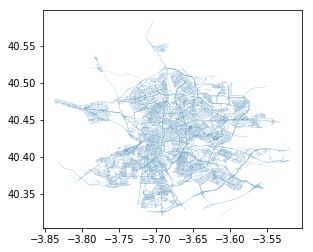

In [5]:
%time streets.plot(linewidth=0.1)

* Load scores

In [6]:
scores = pd.read_json('../data/votes.json').set_index('dm_id')

scores.head()

,value
dm_id,
1001,20.666332
10015,14.019823
10069,16.171495
10070,12.640932
10072,16.070526


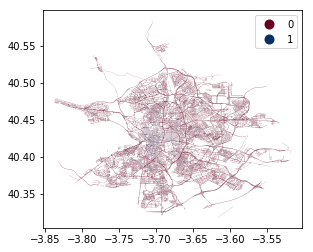

In [7]:
tmp = streets.assign(arturo_score=scores)
tmp['flag'] = 0
tmp.loc[tmp['arturo_score'].notnull(), 'flag'] = 1

tmp.plot(column='flag', categorical=True, legend='True', cmap='RdBu', linewidth=0.1)

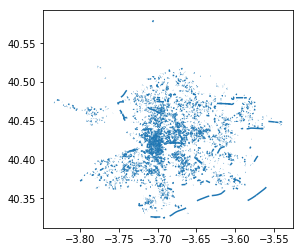

In [8]:
tmp.query('flag == 1').plot()

## Neighbourhoods

In [9]:
neis = gpd.read_file('../data/neighbourhoods.geojson')

In [10]:
neis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 3 columns):
neighbourhood          128 non-null object
neighbourhood_group    128 non-null object
geometry               128 non-null object
dtypes: object(3)
memory usage: 3.1+ KB


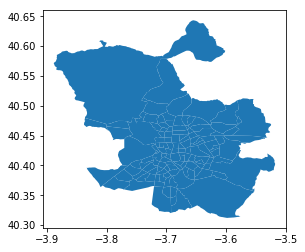

In [11]:
neis.plot()

## AirBnb information

* Read in and parse prices

In [12]:
abb_vars = ['neighbourhood_cleansed', 'price', 'review_scores_location']

abb = pd.read_csv('../data/listings.csv.gz')
abb['price_usd'] = abb['price'].apply(lambda p: float(p.strip('$').replace(',', '')))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


* Aggregate by neighbourhood

In [13]:
abb_nei = abb.groupby('neighbourhood_cleansed')\
             [['review_scores_location', 'price_usd']]\
             .mean()\
             .rename(columns={'review_scores_location': 'abb_review_scores_location',
                              'price_usd': 'abb_price_usd'})
abb_nei['N. Abb'] = abb.groupby('neighbourhood_cleansed')\
                       .size()
abb_nei.head()

,abb_review_scores_location,abb_price_usd,N. Abb
neighbourhood_cleansed,,,
Abrantes,8.666667,41.750000,16
Acacias,9.467532,67.375691,181
Adelfas,9.079365,59.263889,72
Aeropuerto,9.428571,50.444444,9
Aguilas,8.840000,42.586207,29


## Aggregate by neighbourhood

* Get cross-walk from street centroid to neighbourhood

In [14]:
%time walk = gpd.sjoin(gpd.GeoDataFrame({'geometry': streets.centroid, \
                                         'dm_id': streets.index}, \
                                        crs=streets.crs), \
                       neis[['geometry', 'neighbourhood']], \
                       op='within')\
                .set_index('dm_id')['neighbourhood']
walk.head()

CPU times: user 4.91 s, sys: 0 ns, total: 4.91 s
Wall time: 4.75 s


dm_id
1      Valdefuentes
2      Valdefuentes
3      Valdefuentes
149    Valdefuentes
150    Valdefuentes
Name: neighbourhood, dtype: object

* Compare proportion of scored streets by neighbourhood

In [15]:
comp = streets.assign(neighbourhood=walk)\
              .assign(arturo_score=scores)\
              [['arturo_score', 'neighbourhood']]
comp.head()

,arturo_score,neighbourhood
dm_id,,
1,NaN,Valdefuentes
2,NaN,Valdefuentes
3,NaN,Valdefuentes
4,NaN,Canillas
5,NaN,Canillas


In [16]:
counts = pd.DataFrame({'N. streets': comp.groupby('neighbourhood').size(), \
                       'Scored streets': comp.groupby('neighbourhood').count()['arturo_score']})
counts = neis.join(counts, on='neighbourhood')
counts['pct_scored'] = counts['Scored streets'] * 100 / counts['N. streets']

counts.head()

,neighbourhood,neighbourhood_group,geometry,N. streets,Scored streets,pct_scored
0,Palacio,Centro,"(POLYGON ((-3.70584 40.420297, -3.706248 40.42...",604,152,25.165563
1,Embajadores,Centro,"(POLYGON ((-3.703837 40.414318, -3.70277 40.41...",421,134,31.828979
2,Cortes,Centro,"(POLYGON ((-3.697959 40.419286, -3.696453 40.4...",271,100,36.900369
3,Justicia,Centro,"(POLYGON ((-3.695463 40.418977, -3.696453 40.4...",301,97,32.225914
4,Universidad,Centro,"(POLYGON ((-3.701075 40.421339, -3.701547 40.4...",436,168,38.532110


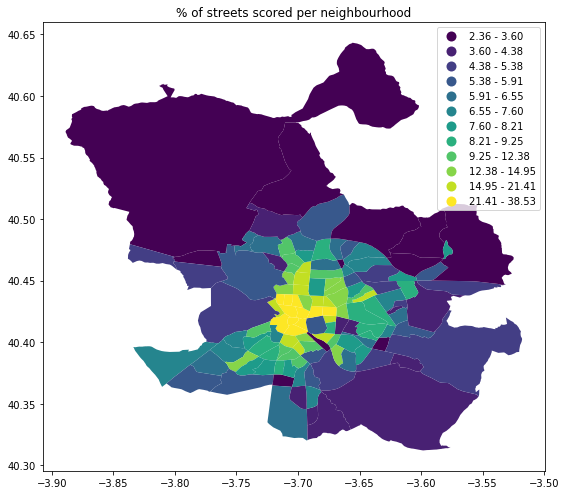

In [17]:
f, ax = plt.subplots(1, figsize=(9, 9))
counts.plot(column='pct_scored', scheme='quantiles', k=12, legend=True, ax=ax)
ax.set_title("% of streets scored per neighbourhood")
plt.show()

* Pull variables to keep and group by neighbourhood, calculating average

In [18]:
db = streets.assign(neighbourhood=walk)\
            .assign(arturo_score=scores)\
            .groupby('neighbourhood')\
            [tokeep + ['arturo_score']]\
            .mean()\
            .join(abb_nei)\
            .join(counts.set_index('neighbourhood')\
                        [['N. streets', 'Scored streets', 'pct_scored']])
db.head()

,land_use_mix,closeness_small_parks,residence_ratio,age_diversity,population_density,arturo_score,abb_review_scores_location,abb_price_usd,N. Abb,N. streets,Scored streets,pct_scored
neighbourhood,,,,,,,,,,,,
Abrantes,0.000144,339.401866,0.553505,0.001201,3766.824717,22.684252,8.666667,41.750000,16.0,354,28,7.909605
Acacias,0.000154,147.768530,0.757358,0.001570,11832.609654,25.578927,9.467532,67.375691,181.0,426,67,15.727700
Adelfas,0.000140,79.538964,0.788278,0.001891,7331.423533,21.209555,9.079365,59.263889,72.0,236,29,12.288136
Aeropuerto,0.000013,492.419842,0.111729,0.000458,228.840471,17.779263,9.428571,50.444444,9.0,790,28,3.544304
Aguilas,0.000050,320.667140,0.494294,0.000412,2811.133166,25.083242,8.840000,42.586207,29.0,590,37,6.271186


* Join to Neighbourhood geometries

In [19]:
gdb = neis.join(db, on='neighbourhood')

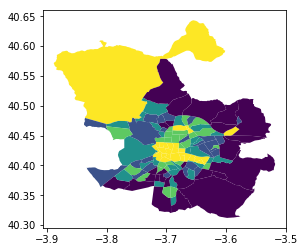

In [20]:
gdb.plot(column='arturo_score', scheme='quantiles')

In [21]:
gdb.to_file('../data/demo_data.gpkg', driver='GPKG')